# Engine power vs emissions

## Problem
In this problem we're trying to optimize a diesel engine for maximum power and minimum CO<sub>2</sub> emissions. Depending on the optimal engine speed, the power and CO<sub>2</sub> emissions change.

The following data is available:

| Rotations per minute | CO<sub>2</sub> Emissions | Power   |
|------|---------------|---------|
| 800  | 708           | 161.141 |
| 1000 | 696.889       | 263.243 |
| 1200 | 688.247       | 330.51  |
| 1400 | 682.897       | 381.561 |
| 1700 | 684.955       | 391.17  |
| 1800 | 697.3         | 370     |

This data is interpolated to obtain a continuous relation:

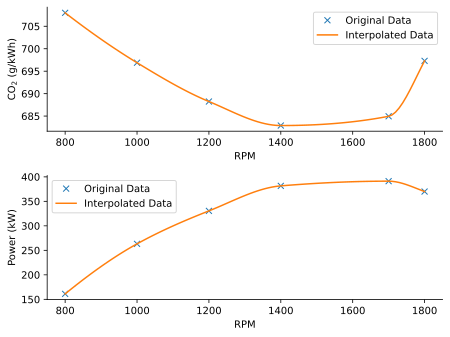

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

RPM = np.array([800, 1000, 1200, 1400, 1700, 1800])
CO2 = np.array([708, 696.889, 688.247, 682.897, 684.955, 697.3 ])
POW = np.array([161.141, 263.243, 330.51 , 381.561, 391.17, 370 ])

def CO2func(s):
    return sp.interpolate.pchip_interpolate(RPM,CO2,s)

def POWfunc(s):
    return sp.interpolate.pchip_interpolate(RPM,POW,s)

RPM_continuous = np.linspace(800,1800,100)
plt.figure()
plt.subplot(2,1,1)
plt.plot(RPM, CO2, 'x', label='Original Data')
plt.plot(RPM_continuous, CO2func(RPM_continuous), label='Interpolated Data')
plt.xlabel('RPM')
plt.ylabel('CO$_2$ (g/kWh)')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
plt.legend()

plt.subplot(2,1,2)
plt.plot(RPM, POW, 'x', label='Original Data')
plt.plot(RPM_continuous, POWfunc(RPM_continuous), label='Interpolated Data')
plt.xlabel('RPM')
plt.ylabel('Power (kW)')
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
plt.legend();


## Model

We'll define the model as follows:
- Design variables: scalar value representing the rotations per minute ($\text{RPM}$)
- Objective function: weighted sum of the power and CO<sub>2</sub> emissions, max of difference with goals or pareto front
- Bounds: only interpolation so between $800$ and $1800$ $\text{RPM}$

### Design variables
Let's start with our design variables. In this case a logical choice could be the width, height and depth of our block

$$ x= \text{rotations per minute} $$

### Objective function

Let's explore all three possible objective functions:

#### Weighted objective function
We can define the weighted objective function with some predefined weights. For example a weight of $\cfrac{1}{3}$ for the power value and $\cfrac{2}{3}$ for the CO<sub>2</sub> emissions.

$$ \mathop {\min }\limits_x \left( -\cfrac{1}{3} \cdot f_{\text{power}}\left( x \right) + \cfrac{2}{3} \cdot f_{\text{CO}_2\text{ emissions}}\left( x \right) \right) $$

Please note that we need a minus for the power objective because it's an maximization objective and we now apply the weights to the non-normalized functions while they have different units. Therefore, it might be wise to apply normalization.

#### Goal attainment
If we define two fails for the power and CO<sub>2</sub> emissions, we can apply goal attainment. Those goals could be $460 \text{ kW}$ for the generated power and $640 \text{ g/kWh}$ for the CO<sub>2</sub> emissions. Now the objective function can as:

$$ \mathop {\min }\limits_x \left( {\max \left( {460 - {f_{{\rm{power}}}}\left( x \right),{f_{{\rm{C}}{{\rm{O}}_2}{\rm{ emissions}}}}\left( x \right) - 640} \right)} \right)$$

#### Pareto front
Finally, we can find the pareto front by defining the problem as:

$$  \mathop {\min }\limits_x \left( - {{\delta }_{i}} \cdot f_{\text{power},\text{normalized}}\left( x \right) +  \delta_j \cdot f_{\text{CO}_2\text{ emissions},\text{normalized}}\left( x \right) \right) $$

For normalization, we could take the value from our plot, but for more real-life complex problems the dimensions are higher and you cannot find the maximum and minimum of each single objective function. Therefore, let's estimate the maxima and minima as:

|  | CO<sub>2</sub> Emissions | Power   |
|------|---------------|---------|
| Minimum value  | 680       | 150 |
| Maximum value | 710       | 400 |

This gives:

$$\begin{matrix}
  {{f}_{\text{power, normalized}}}\left( x \right)=\cfrac{f_{\text{power}}\left( x \right)- 150}{400-150} \\ 
  {{f}_{\text{CO}_2\text{ emissions},\text{normalized}}}\left( x \right)=\cfrac{f_{\text{CO}_2\text{ emissions}}\left( x \right)- 680}{710-680} \\ 
\end{matrix}$$

To find the full pareto front this optimization model has to be solved for a large set of $\delta_i$ and $\delta_j$

### Bounds

Let's limit our solution to within our interpolation domain. Therefore, the bound can be defined as:

$$ 800<x < 1800$$

### Find best solution manually

Try and adjust the values for $x$. Can you find the optimal solution? How does it change for different models?

## Method

Now let's solve this problem using an optimization method. The interpolated data is stored in `CO2func` and `POWfunc`.

In [3]:
from ipywidgets import widgets, interact

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

RPM = np.array([800, 1000, 1200, 1400, 1700, 1800])
CO2 = np.array([708, 696.889, 688.247, 682.897, 684.955, 697.3 ])
POW = np.array([161.141, 263.243, 330.51 , 381.561, 391.17, 370 ])

def weighted_obj(s):
    delta_p = 1/3
    delta_c = 1 - delta_p
    return -delta_p * POWfunc(s) + delta_c * CO2func(s)

Pt = 460
Ct = 640
def goal_attainment(s):
    return max(Pt - POWfunc(s),CO2func(s)-Ct)

def CO2func(s):
    return sp.interpolate.pchip_interpolate(RPM,CO2,s)

def POWfunc(s):
    return sp.interpolate.pchip_interpolate(RPM,POW,s)

def func(x):
    fig, ax = plt.subplots(1, 1)
    ax.clear()
    ax.plot(CO2func(x),POWfunc(x),'x')
    ax.set_xlim([680,710])
    ax.set_ylim([150,400])
    ax.invert_yaxis()
    ax.set_xlabel('CO$_2$ (g/kWh)')
    ax.set_ylabel('Power functions (kW)')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.set_title('CO$_2$ vs Power')
    plt.draw()
    weighted_obj_val = weighted_obj(x)
    goal_attainment_val = goal_attainment(x)
    print('Weighted 🏋️ Objective:',weighted_obj_val)
    print('Goal 🥅 Attainment:',goal_attainment_val)

interact(func, x = widgets.IntSlider(min=800, max=1800, value=1000, step=1, description="RPM"));

interactive(children=(IntSlider(value=1000, description='RPM', max=1800, min=800), Output()), _dom_classes=('w…

<iframe src="https://tudelft.h5p.com/content/1292260165388503037/embed" aria-label="Pareto optimal" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>

### Import libraries

In [4]:
import scipy as sp 
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

### Define variables
As before, we don't need to specify our variable $x$ itself. However, this optimization method requires an initial guess. An arbitrary value is chosen here:

In [5]:
RPM = np.array([800, 1000, 1200, 1400, 1700, 1800])
CO2 = np.array([708, 696.889, 688.247, 682.897, 684.955, 697.3 ])
POW = np.array([161.141, 263.243, 330.51 , 381.561, 391.17, 370 ])

def CO2func(s):
    return sp.interpolate.pchip_interpolate(RPM,CO2,s)

def POWfunc(s):
    return sp.interpolate.pchip_interpolate(RPM,POW,s);

In [6]:
x0 = np.array(1200)

### Define objective function

Let's define the objective function for each of the three models

#### Weighted objective function

The objective function gives:

In [7]:
def weighted_obj(x):
    delta_p = 1/3
    delta_c = 1 - delta_p
    return -delta_p * POWfunc(x) + delta_c * CO2func(x)

#### Goal attainment

The objective function gives:

In [8]:
def goal_attainment(x):
    Pt = 460
    Ct = 640
    return max(Pt - POWfunc(x),CO2func(x)-Ct)

#### Pareto front

For the pareto front, the objective functions needed to be normalized:

In [9]:
def POWfunc_normalized(x):
    return (POWfunc(x) - 150)/(400 - 150)

def CO2func_normalized(x):
    return (CO2func(x) - 680)/(710 - 680)

The objective function gives:

In [10]:
def weighted_obj_pareto(x):
    return -delta_p * POWfunc_normalized(x) + delta_c * CO2func_normalized(x)

in which `delta_p` and `delta_c` are defined when solving this problem

### Define bounds
The one single bound results in:

In [12]:
bounds = [[800,1800]]

### Solve the problem

Now let's solve the problem for each of the three models. We're gonna time them to see how long the analysis takes.

#### Weighted objective function

In [13]:
%%time
result = sp.optimize.minimize(fun = weighted_obj, x0 = x0, bounds = bounds)
print(result)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 325.81425292950235
        x: [ 1.613e+03]
      nit: 7
      jac: [-5.684e-06]
     nfev: 26
     njev: 13
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 14.8 ms


#### Goal attainment

In [14]:
%%time
result2 = sp.optimize.minimize(fun = goal_attainment, x0 = x0, bounds=bounds)
print(result2)

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 68.83000008096866
        x: [ 1.700e+03]
      nit: 12
      jac: [-5.684e-06]
     nfev: 50
     njev: 25
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
CPU times: total: 15.6 ms
Wall time: 25.8 ms


#### Pareto front

For the pareto front we need to solve this problem for a collection of weights. The results are stored in a list

In [15]:
%%time
x_pareto_opt =[]
delta_p_list = np.linspace(0,1,101)
delta_c_list = 1 - delta_p_list
for i in range(101):
    delta_p = delta_p_list[i]
    delta_c = delta_c_list[i]
    result_i = sp.optimize.minimize(fun = weighted_obj_pareto,x0=x0,bounds=bounds)
    x_pareto_opt.append(result_i.x[0])

CPU times: total: 812 ms
Wall time: 824 ms


Now the pareto front can be plotted by evaluating the objectives functions for our collection of optimum values for $x$:

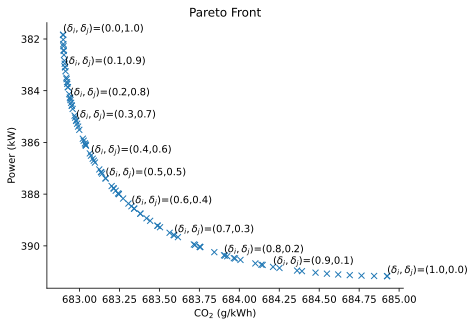

In [16]:
P_pareto_opt = POWfunc(x_pareto_opt)
C_pareto_opt = CO2func(x_pareto_opt)

plt.figure()
plt.plot(C_pareto_opt,P_pareto_opt,'x')
for i in range(101):
    if i%10 == 0:
        plt.annotate(f"($\delta_i,\delta_j$)=({round(delta_p_list[i],1)},{round(delta_c_list[i],1)})", (C_pareto_opt[i], P_pareto_opt[i]), ha='left',va = 'bottom')
plt.ylabel('Power (kW)')
plt.xlabel('CO$_2$ (g/kWh)')
plt.title('Pareto Front')
ax = plt.gca()
ax.invert_yaxis()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

<iframe src="https://tudelft.h5p.com/content/1292260179152459667/embed" aria-label="Best model" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>
<iframe src="https://tudelft.h5p.com/content/1292260184374358717/embed" aria-label="Timeing" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>

## Exercise

Click {fa}`rocket` --> {guilabel}`Live Code` and answer the following question:
<iframe src="https://tudelft.h5p.com/content/1292260188487459217/embed" aria-label="Not normalization" width="1088" height="637" frameborder="0" allowfullscreen="allowfullscreen" allow="autoplay *; geolocation *; microphone *; camera *; midi *; encrypted-media *"></iframe><script src="https://tudelft.h5p.com/js/h5p-resizer.js" charset="UTF-8"></script>